# ECG Beat Detector Training

**Layer 1**: CNN-Transformer model for beat detection + classification (Normal / PVC / Other)

- CNN encoder captures local QRS morphology
- Transformer captures rhythm context (premature timing, regularity)
- Dual heads: beat probability + class logits
- Input: 20s segments (2500 samples @ 125 Hz) → Output: beat list with timing + class

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from collections import Counter

sys.path.insert(0, '.')
from ecg_library.beat_dataset import (
    build_datasets, collate_fn, ECGBeatDataset,
    _build_index, CLASS_NAMES, NUM_CLASSES, SAMPLES_PER_SEGMENT, DS_LENGTH,
)
from ecg_library.beat_detector import (
    CNNTransformerDetector, compute_loss, detect_beats, evaluate_detection,
)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Device: {device}')

Device: mps


## 1. Load Dataset & Inspect Split

In [2]:
import pandas as pd
import random
from collections import defaultdict

# --- Session lists ---
# Curated: human corrections applied via annotations.csv
ann_df = pd.read_csv('annotations.csv')
annotated_sessions = sorted(ann_df['session'].unique().tolist())

# Extra: algo labels used as ground truth (no human review).
# Chosen from sessions with moderate PVC rates (3–8%) where the rule-based
# algo is most reliable. Spread across Aug 2024 – Jan 2026 for diversity.
EXTRA_SLEEP_SESSIONS = [
    'Sleep_on_20240809_230342_by_Etienne_5010176_94DEB87F66D7_RAWECG',  # Aug 2024  7.5%
    'Sleep_on_20250409_215639_by_Etienne_5010176_8CF6812E7FAF_RAWECG',  # Apr 2025  7.9%
    'Sleep_on_20250605_231511_by_Etienne_5010176_8CF6812E7FAF_RAWECG',  # Jun 2025  5.2%
    'Sleep_on_20250613_221247_by_Etienne_5010176_8CF6812E7FAF_RAWECG',  # Jun 2025  5.1%
    'Sleep_on_20250617_230912_by_Etienne_5010176_8CF6812E7FAF_RAWECG',  # Jun 2025  4.7%
    'Sleep_on_20250621_223535_by_Etienne_5010176_8CF6812E7FAF_RAWECG',  # Jun 2025  6.3%
    'Sleep_on_20250628_215326_by_Etienne_5010176_8CF6812E7FAF_RAWECG',  # Jun 2025  3.6%
    'Sleep_on_20250706_223216_by_Etienne_5010176_8CF6812E7FAF_RAWECG',  # Jul 2025  6.5%
    'Sleep_on_20250713_224009_by_Etienne_5010176_8CF6812E7FAF_RAWECG',  # Jul 2025  6.7%
    'Sleep_on_20250718_230409_by_Etienne_5010176_8CF6812E7FAF_RAWECG',  # Jul 2025  6.2%
    'Sleep_on_20250727_170026_by_Etienne_5010176_8CF6812E7FAF_RAWECG',  # Jul 2025  7.2%
    'Sleep_on_20250917_224131_by_Etienne_5010176_8CF6812E7FAF_RAWECG',  # Sep 2025  3.8%
    'Sleep_on_20250927_222407_by_Etienne_5010176_8CF6812E7FAF_RAWECG',  # Sep 2025  7.3%
    'Sleep_on_20251001_230212_by_Etienne_5010176_8CF6812E7FAF_RAWECG',  # Oct 2025  5.2%
    'Sleep_on_20260126_230220_by_Etienne_5010176_8CF6812E7FAF_RAWECG',  # Jan 2026  3.9%
]
EXTRA_REST_SESSIONS = [
    'Rest_on_20240809_132445_by_Etienne_5010176_94DEB87F66D7_RAWECG',   # Aug 2024  4.8%
    'Rest_on_20250702_062110_by_Etienne_5010176_8CF6812E7FAF_RAWECG',   # Jul 2025  6.5%
    'Rest_on_20250724_231654_by_Etienne_5010176_8CF6812E7FAF_RAWECG',   # Jul 2025  3.7%
    'Rest_on_20251021_070342_by_Etienne_5010176_8CF6812E7FAF_RAWECG',   # Oct 2025  5.1%
    'Rest_on_20260128_130651_by_Etienne_5010176_8CF6812E7FAF_RAWECG',   # Jan 2026  5.3%
]
EXTRA_SESSIONS = EXTRA_SLEEP_SESSIONS + EXTRA_REST_SESSIONS

all_sessions = set(annotated_sessions) | set(EXTRA_SESSIONS)
print(f"Curated sessions:         {len(annotated_sessions)}")
print(f"Extra (algo-label) sleep: {len(EXTRA_SLEEP_SESSIONS)}")
print(f"Extra (algo-label) rest:  {len(EXTRA_REST_SESSIONS)}")
print(f"Total sessions:           {len(all_sessions)}")

# Build index — human corrections applied as overrides where they exist
index, _ = _build_index('Data', 'annotations.csv')
curated_index = [e for e in index if e['session'] in all_sessions]
print(f"\nTotal segments (before filtering): {len(curated_index)}")

# --- Apply training filters ---
# 1. Remove first 2 min (6 segments) and last 1 min (3 segments) of each session
SKIP_START = 6
SKIP_END   = 3
before = len(curated_index)
curated_index = [
    e for e in curated_index
    if e['segment_idx'] >= SKIP_START
    and e['segment_idx'] < (e['n_segments'] - SKIP_END)
]
print(f"  After trimming start/end: {len(curated_index)} ({before - len(curated_index)} removed)")

# 2. Remove segments with artifacts
before = len(curated_index)
curated_index = [e for e in curated_index if not e['has_artifact']]
print(f"  After removing artifacts: {len(curated_index)} ({before - len(curated_index)} removed)")

# 3. Remove segments with only normal beats
before = len(curated_index)
curated_index = [e for e in curated_index if not e['all_normal']]
print(f"  After removing all-normal: {len(curated_index)} ({before - len(curated_index)} removed)")

print(f"\nFiltered segments: {len(curated_index)}")

# --- Per-session 80/20 split ---
VAL_RATIO = 0.20
SEED = 42
rng = random.Random(SEED)

train_idx, val_idx = [], []
by_session = defaultdict(list)
for e in curated_index:
    by_session[e['session']].append(e)

print("\nPer-session split (80% train / 20% val):")
for sess in sorted(by_session.keys()):
    tag = '[curated]' if sess in annotated_sessions else '[algo]   '
    segs = by_session[sess][:]
    rng.shuffle(segs)
    n_val = max(1, round(len(segs) * VAL_RATIO))
    val_idx.extend(segs[:n_val])
    train_idx.extend(segs[n_val:])
    print(f"  {tag} {sess[-52:]}: {len(segs)} segs → train={len(segs)-n_val}  val={n_val}")

train_ds = ECGBeatDataset(train_idx, augment=True)
val_ds   = ECGBeatDataset(val_idx,   augment=False)
test_ds  = val_ds  # reuse val as test

split_info = {
    'curated_sessions': annotated_sessions,
    'extra_sessions': EXTRA_SESSIONS,
    'total_sessions': len(all_sessions),
    'train_segments': len(train_idx),
    'val_segments': len(val_idx),
    'total_segments': len(curated_index),
    'val_ratio': VAL_RATIO,
    'split_seed': SEED,
}

print(f"\nTotal: {len(train_idx)} train + {len(val_idx)} val segments")

# Count beats per class in training set
train_counts = Counter()
for entry in train_ds.index:
    for _, cls in entry['beats']:
        train_counts[cls] += 1
print(f"\nTraining beats by class:")
for cls_id, name in CLASS_NAMES.items():
    print(f"  {name} ({cls_id}): {train_counts.get(cls_id, 0):,}")

Curated sessions:         5
Extra (algo-label) sleep: 15
Extra (algo-label) rest:  5
Total sessions:           25

Total segments (before filtering): 27640
  After trimming start/end: 27406 (234 removed)
  After removing artifacts: 27386 (20 removed)
  After removing all-normal: 15650 (11736 removed)

Filtered segments: 15650

Per-session split (80% train / 20% val):
  [curated] 260224_083522_by_Etienne_5010176_8CF6812E7FAF_RAWECG: 85 segs → train=68  val=17
  [algo]    240809_132445_by_Etienne_5010176_94DEB87F66D7_RAWECG: 131 segs → train=105  val=26
  [algo]    250702_062110_by_Etienne_5010176_8CF6812E7FAF_RAWECG: 146 segs → train=117  val=29
  [algo]    250724_231654_by_Etienne_5010176_8CF6812E7FAF_RAWECG: 474 segs → train=379  val=95
  [algo]    251021_070342_by_Etienne_5010176_8CF6812E7FAF_RAWECG: 379 segs → train=303  val=76
  [algo]    260128_130651_by_Etienne_5010176_8CF6812E7FAF_RAWECG: 564 segs → train=451  val=113
  [curated] 260215_080409_by_Etienne_5010176_8CF6812E7FAF_RAW

## 2. Visualize Samples with Heatmap Targets

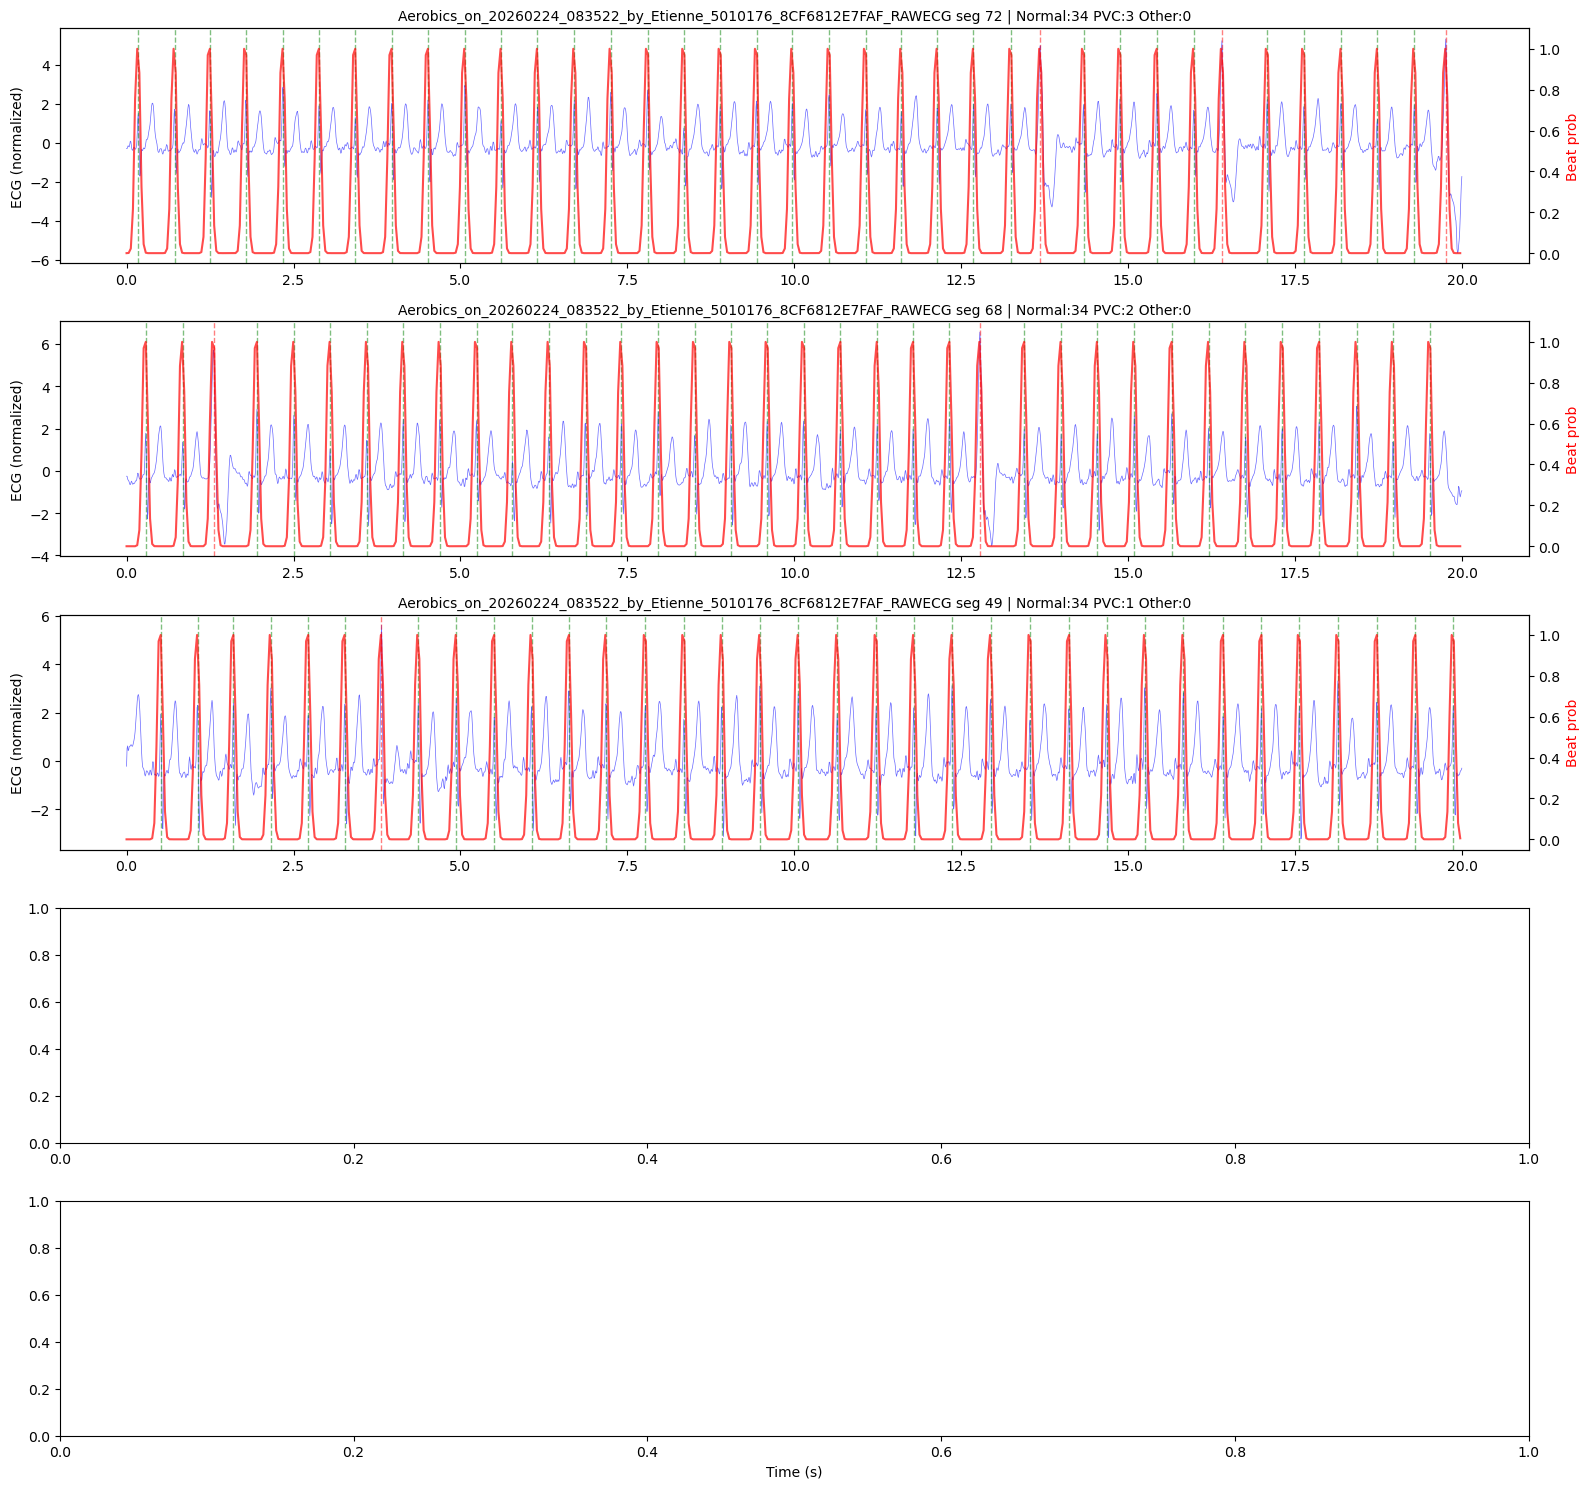

In [3]:
fig, axes = plt.subplots(5, 1, figsize=(16, 15))

# Find diverse samples: some with PVCs
pvc_samples = [i for i, e in enumerate(val_ds.index) if any(c == 2 for _, c in e['beats'])][:3]
normal_samples = [i for i, e in enumerate(val_ds.index) if all(c == 1 for _, c in e['beats'])][:2]
sample_indices = pvc_samples + normal_samples
sample_indices = sample_indices[:5]

for ax_idx, ds_idx in enumerate(sample_indices):
    sample = val_ds[ds_idx]
    signal = sample['signal'].squeeze().numpy()
    heatmap = sample['beat_heatmap'].numpy()
    class_map = sample['class_map'].numpy()

    ax = axes[ax_idx]
    t_signal = np.arange(SAMPLES_PER_SEGMENT) / 125
    t_ds = np.arange(DS_LENGTH) / (125 / 4)

    ax.plot(t_signal, signal, 'b-', alpha=0.6, linewidth=0.5, label='ECG')

    ax2 = ax.twinx()
    ax2.plot(t_ds, heatmap, 'r-', alpha=0.7, linewidth=1.5, label='Beat heatmap')

    # Mark beat types from class_map
    for r_idx, cls_id in sample['beats']:
        t = r_idx / 125
        color = {'1': 'green', '2': 'red', '0': 'orange'}.get(str(cls_id), 'gray')
        label = CLASS_NAMES.get(cls_id, '?')
        ax.axvline(t, color=color, alpha=0.5, linewidth=1, linestyle='--')

    n_normal = sum(1 for _, c in sample['beats'] if c == 1)
    n_pvc = sum(1 for _, c in sample['beats'] if c == 2)
    n_other = sum(1 for _, c in sample['beats'] if c == 0)
    ax.set_title(f"{sample['session']} seg {sample['segment_idx']} | "
                 f"Normal:{n_normal} PVC:{n_pvc} Other:{n_other}", fontsize=10)
    ax.set_ylabel('ECG (normalized)')
    ax2.set_ylabel('Beat prob', color='red')
    ax2.set_ylim(-0.05, 1.1)

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

## 3. Model & Training Setup

In [4]:
# Compute class weights (inverse frequency) + focal loss to handle imbalance
total_beats = sum(train_counts.values())
base_weights = [
    total_beats / (NUM_CLASSES * max(train_counts.get(i, 1), 1))
    for i in range(NUM_CLASSES)
]
class_weights = torch.tensor(base_weights, dtype=torch.float32).to(device)
FOCAL_GAMMA = 2.0
CLASS_LOSS_WEIGHT = 2.0  # upweight classification vs detection
print(f"Class weights: {class_weights}")
print(f"Focal gamma={FOCAL_GAMMA}, class_loss_weight={CLASS_LOSS_WEIGHT}")

# Model
model = CNNTransformerDetector(
    d_model=128, nhead=8, dim_ff=256, num_layers=4,
    num_classes=NUM_CLASSES, dropout=0.1,
).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params:,}")

# Warm-start: load weights from previous best checkpoint if available.
# The model initialises from learned representations rather than random weights,
# which means it converges faster when you add new sessions.
# The optimizer always resets — you want fresh momentum when fine-tuning on new data.
CHECKPOINT_PATH = 'ecg_beat_detector_best.pt'
if os.path.exists(CHECKPOINT_PATH):
    ckpt = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=False)
    model.load_state_dict(ckpt['model_state_dict'])
    print(f"Warm-start: loaded weights from epoch {ckpt['epoch'] + 1} "
          f"(Det F1={ckpt['val_f1']:.4f}, PVC Rec={ckpt['pvc_recall']:.4f}, "
          f"EMA={ckpt['ema_score']:.4f})")
else:
    print("No checkpoint found — training from random initialisation.")

# torch.compile has a known MPS inductor bug in PyTorch 2.x with dynamic batch
# shapes in BatchNorm (fails on first forward, not at compile time). Skip on MPS.
if device.type != 'mps':
    try:
        model = torch.compile(model)
        print("torch.compile: enabled")
    except Exception:
        print("torch.compile: not available, using eager mode")
else:
    print("torch.compile: skipped on MPS (inductor BatchNorm bug in PyTorch 2.x)")

# Fresh optimizer and scheduler — always reset when starting a new training run
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

Class weights: tensor([45.6216,  0.3727,  3.3933], device='mps:0')
Focal gamma=2.0, class_loss_weight=2.0
Model parameters: 666,884
Warm-start: loaded weights from epoch 47 (Det F1=0.9121, PVC Rec=0.3605, EMA=0.6335)
torch.compile: skipped on MPS (inductor BatchNorm bug in PyTorch 2.x)


## 4. Training Loop

In [ ]:
BATCH_SIZE = 64   # larger batches amortize MPS kernel overhead
NUM_EPOCHS = 50
PATIENCE = 15    # increased from 10 — PVC recall is noisy on small val sets

# EMA smoothing for early stopping: prevents a single lucky epoch from
# saving a checkpoint that isn't genuinely better, and avoids early stopping
# after a string of unlucky-but-not-worse epochs.
EMA_ALPHA = 0.3   # 0.3 = ~3-4 epoch effective window

# Device-specific data loading settings
pin_memory  = device.type == 'cuda'   # faster CPU→GPU transfer on CUDA
num_workers = 4 if device.type == 'cuda' else 0  # parallel workers on CUDA
ema_score  = None # initialised on first epoch

# Oversample PVC-containing segments so model sees more PVC morphology
from torch.utils.data import WeightedRandomSampler
PVC_OVERSAMPLE = 5.0
sample_weights = []
n_pvc_segs = 0
for entry in train_ds.index:
    has_pvc = any(c == 2 for _, c in entry['beats'])
    if has_pvc:
        sample_weights.append(PVC_OVERSAMPLE)
        n_pvc_segs += 1
    else:
        sample_weights.append(1.0)
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
print(f"PVC segments: {n_pvc_segs}/{len(train_ds)} ({100*n_pvc_segs/len(train_ds):.1f}%), oversampled {PVC_OVERSAMPLE}x")

# pin_memory is not supported on MPS — keep False to avoid the warning
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, sampler=sampler,
    collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory,
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory,
)

history = {'train_loss': [], 'val_loss': [], 'val_detect_f1': [], 'val_pvc_recall': [],
           'combined_score': [], 'ema_score': [], 'lr': []}
best_ema_score  = 0.0
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    # --- Train ---
    model.train()
    train_losses = []
    for batch in train_loader:
        signal = batch['signal'].to(device)
        beat_target = batch['beat_heatmap'].to(device)
        class_target = batch['class_map'].to(device)

        beat_prob, class_logits = model(signal)
        loss, loss_dict = compute_loss(
            beat_prob, class_logits, beat_target, class_target,
            pos_weight=10.0, class_weights=class_weights,
            focal_gamma=FOCAL_GAMMA, class_loss_weight=CLASS_LOSS_WEIGHT,
        )

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_losses.append(loss_dict['total'])

    scheduler.step()

    # --- Validate ---
    model.eval()
    val_losses = []
    all_metrics = []
    with torch.no_grad():
        for batch in val_loader:
            signal = batch['signal'].to(device)
            beat_target = batch['beat_heatmap'].to(device)
            class_target = batch['class_map'].to(device)

            beat_prob, class_logits = model(signal)
            loss, loss_dict = compute_loss(
                beat_prob, class_logits, beat_target, class_target,
                pos_weight=10.0, class_weights=class_weights,
                focal_gamma=FOCAL_GAMMA, class_loss_weight=CLASS_LOSS_WEIGHT,
            )
            val_losses.append(loss_dict['total'])

            for i in range(signal.size(0)):
                pred = detect_beats(beat_prob[i], class_logits[i])
                true = batch['beats'][i]
                metrics = evaluate_detection(pred, true)
                all_metrics.append(metrics)

    # Aggregate validation metrics
    total_tp = sum(m['tp'] for m in all_metrics)
    total_fp = sum(m['fp'] for m in all_metrics)
    total_fn = sum(m['fn'] for m in all_metrics)
    val_prec = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    val_rec  = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    val_f1   = 2 * val_prec * val_rec / (val_prec + val_rec) if (val_prec + val_rec) > 0 else 0

    pvc_tp = sum(m['per_class'].get('PVC', {}).get('tp', 0) for m in all_metrics)
    pvc_fn = sum(m['per_class'].get('PVC', {}).get('fn', 0) for m in all_metrics)
    pvc_recall = pvc_tp / (pvc_tp + pvc_fn) if (pvc_tp + pvc_fn) > 0 else 0

    combined_score = 0.5 * val_f1 + 0.5 * pvc_recall

    # EMA smoothing — checkpoint and early stopping use smoothed score
    ema_score = (EMA_ALPHA * combined_score + (1 - EMA_ALPHA) * ema_score
                 if ema_score is not None else combined_score)

    avg_train_loss = np.mean(train_losses)
    avg_val_loss   = np.mean(val_losses)
    current_lr     = scheduler.get_last_lr()[0]

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_detect_f1'].append(val_f1)
    history['val_pvc_recall'].append(pvc_recall)
    history['combined_score'].append(combined_score)
    history['ema_score'].append(ema_score)
    history['lr'].append(current_lr)

    print(f"Epoch {epoch+1:2d}/{NUM_EPOCHS} | "
          f"Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} | "
          f"F1: {val_f1:.4f} | PVC Rec: {pvc_recall:.4f} | "
          f"Score: {combined_score:.4f} | EMA: {ema_score:.4f} | LR: {current_lr:.6f}")

    if ema_score > best_ema_score:
        best_ema_score = ema_score
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
            'pvc_recall': pvc_recall,
            'combined_score': combined_score,
            'ema_score': ema_score,
            'history': history,
        }, 'ecg_beat_detector_best.pt')
        print(f"  -> New best EMA! Saved checkpoint.")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"  -> Early stopping after {PATIENCE} epochs without EMA improvement.")
            break

print(f"\nBest EMA score: {best_ema_score:.4f}")

PVC segments: 12043/12520 (96.2%), oversampled 5.0x


## 5. Validation Curves

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

epochs = range(1, len(history['train_loss']) + 1)

axes[0, 0].plot(epochs, history['train_loss'], label='Train')
axes[0, 0].plot(epochs, history['val_loss'], label='Val')
axes[0, 0].set_title('Loss')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Epoch')

axes[0, 1].plot(epochs, history['val_detect_f1'], 'g-')
axes[0, 1].set_title('Val Beat Detection F1')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylim(0, 1)

axes[1, 0].plot(epochs, history['val_pvc_recall'], 'r-')
axes[1, 0].set_title('Val PVC Recall')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylim(0, 1)

axes[1, 1].plot(epochs, history['lr'], 'k-')
axes[1, 1].set_title('Learning Rate')
axes[1, 1].set_xlabel('Epoch')

plt.tight_layout()
plt.show()

## 6. Test Evaluation

In [ ]:
# Load best checkpoint
checkpoint = torch.load('ecg_beat_detector_best.pt', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Loaded checkpoint from epoch {checkpoint['epoch'] + 1} (val F1: {checkpoint['val_f1']:.4f})")

test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False,
    collate_fn=collate_fn, num_workers=0,
)

all_metrics = []
with torch.no_grad():
    for batch in test_loader:
        signal = batch['signal'].to(device)
        beat_prob, class_logits = model(signal)

        for i in range(signal.size(0)):
            pred = detect_beats(beat_prob[i], class_logits[i])
            true = batch['beats'][i]
            metrics = evaluate_detection(pred, true)
            all_metrics.append(metrics)

# Aggregate
total_tp = sum(m['tp'] for m in all_metrics)
total_fp = sum(m['fp'] for m in all_metrics)
total_fn = sum(m['fn'] for m in all_metrics)
test_prec = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
test_rec = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
test_f1 = 2 * test_prec * test_rec / (test_prec + test_rec) if (test_prec + test_rec) > 0 else 0
timing_mae = np.mean([m['timing_mae_ms'] for m in all_metrics if m['timing_mae_ms'] > 0])

print(f"\n{'='*50}")
print(f"TEST RESULTS ({len(all_metrics)} segments)")
print(f"{'='*50}")
print(f"Beat Detection:  P={test_prec:.4f}  R={test_rec:.4f}  F1={test_f1:.4f}")
print(f"Timing MAE:      {timing_mae:.1f} ms")
print()

# Per-class
for cname in ['Normal', 'PVC', 'Other']:
    c_tp = sum(m['per_class'].get(cname, {}).get('tp', 0) for m in all_metrics)
    c_fp = sum(m['per_class'].get(cname, {}).get('fp', 0) for m in all_metrics)
    c_fn = sum(m['per_class'].get(cname, {}).get('fn', 0) for m in all_metrics)
    c_prec = c_tp / (c_tp + c_fp) if (c_tp + c_fp) > 0 else 0
    c_rec = c_tp / (c_tp + c_fn) if (c_tp + c_fn) > 0 else 0
    c_f1 = 2 * c_prec * c_rec / (c_prec + c_rec) if (c_prec + c_rec) > 0 else 0
    print(f"  {cname:8s}: P={c_prec:.4f}  R={c_rec:.4f}  F1={c_f1:.4f}  (TP={c_tp} FP={c_fp} FN={c_fn})")

## 7. Visual Predictions vs Ground Truth

In [ ]:
# Pick some test segments with PVCs for visualization
pvc_test = [i for i, e in enumerate(test_ds.index) if any(c == 2 for _, c in e['beats'])][:3]
normal_test = [i for i, e in enumerate(test_ds.index) if all(c == 1 for _, c in e['beats'])][:2]
vis_indices = (pvc_test + normal_test)[:5]

fig, axes = plt.subplots(len(vis_indices), 1, figsize=(16, 4 * len(vis_indices)))
if len(vis_indices) == 1:
    axes = [axes]

model.eval()
with torch.no_grad():
    for ax_idx, ds_idx in enumerate(vis_indices):
        sample = test_ds[ds_idx]
        signal = sample['signal'].unsqueeze(0).to(device)
        beat_prob, class_logits = model(signal)

        pred = detect_beats(beat_prob[0], class_logits[0])
        true_beats = sample['beats']

        ecg = sample['signal'].squeeze().numpy()
        t = np.arange(SAMPLES_PER_SEGMENT) / 125

        ax = axes[ax_idx]
        ax.plot(t, ecg, 'b-', alpha=0.5, linewidth=0.5)

        # Ground truth beats
        for r_idx, cls_id in true_beats:
            color = {1: 'green', 2: 'red', 0: 'orange'}.get(cls_id, 'gray')
            ax.axvline(r_idx / 125, color=color, alpha=0.4, linewidth=1, linestyle='--')

        # Predicted beats
        for p_idx, p_class, p_conf in pred:
            marker = {'Normal': 'v', 'PVC': 's', 'Other': 'D'}.get(p_class, 'o')
            color = {'Normal': 'green', 'PVC': 'red', 'Other': 'orange'}.get(p_class, 'gray')
            ax.plot(p_idx / 125, ecg[min(p_idx, len(ecg)-1)], marker, color=color,
                    markersize=8, alpha=0.8)

        metrics = evaluate_detection(pred, true_beats)
        ax.set_title(
            f"{sample['session']} seg {sample['segment_idx']} | "
            f"F1={metrics['f1']:.2f} P={metrics['precision']:.2f} R={metrics['recall']:.2f} | "
            f"True: {len(true_beats)} Pred: {len(pred)}",
            fontsize=10,
        )
        ax.set_ylabel('ECG')

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

print("Legend: dashed lines = ground truth, markers = predictions")
print("  Green = Normal, Red = PVC, Orange = Other")

## 8. Save Final Checkpoint

In [ ]:
# Save final model with metadata
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'd_model': 128, 'nhead': 8, 'dim_ff': 256,
        'num_layers': 4, 'num_classes': NUM_CLASSES, 'dropout': 0.1,
    },
    'class_names': CLASS_NAMES,
    'class_weights': class_weights.cpu(),
    'split_info': split_info,
    'history': history,
    'test_f1': test_f1,
    'test_precision': test_prec,
    'test_recall': test_rec,
}, 'ecg_beat_detector_final.pt')

print('Saved ecg_beat_detector_final.pt')
print(f'Test F1: {test_f1:.4f}')